## 1. Importing Libraries and Generally Creating Environment

In [96]:
import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt                  
import seaborn as sns  
from scipy import stats
import statsmodels.api as sm
from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)
import math
import random

In [5]:
# this is for prediction model that I want to try for myself
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [6]:
# I want to see all rowsc and columns that I indicated and whole arrays and lists (e.g. in commands like value_counts)
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 2. Exploratory Data Analysis

### 2.0 Data Examination and Understanding

In [ ]:
print('Reading and appending our data....')
df1 = pd.read_csv('Data/2019-Oct.csv')
print('Only first part. Still waiting 667...')
df2 = pd.read_csv('Data/2019-Nov.csv')
df = df1.append(df2)
print('Ready!')

Reading and appending our data....


In [ ]:
df.shape #This is really a lot of data

In [ ]:
# This is a code where I tried to extract random 1 % of unique user ids so that there will be less data.
# I did this because the previous data was too large and it took too much time to compute.
# Firstly I applied this logic to user sessions then I understood that one user could have multiple sessions. 
print('Leaving only 1 % of unique users')
u = df['user_id'].unique().tolist()
length = len(u)*0.01
u = random.sample(u, math.floor(length))
df = df[df.user_id.isin(u)]
# Here I tried to achieve my goal by dropping duplicates: took too much time. 
# user_session = df['user_session']
# user_session = user_session.drop_duplicates()
# user_session = user_session.sample(frac=0.25)
# user_session.shape

In [ ]:
df.shape # 90 % decrease in amount of data which will increase our speed of computing. GOOD!

### 2.1 RQ1

##### 2.1.1 Q1

What’s the operation users repeat more on average within a session? Produce a plot that shows the average number of times users perform each operation (view/removefromchart etc etc).

In [34]:
print(df.columns)

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')


In [48]:
df.user_session.value_counts().head(20) # understanding user sessions

4c8fbbcd-84d6-475f-8f25-0aa063707e4a    274
c37e0de6-9406-4ad6-9dac-5cd428ea649d    192
a7081bbb-82b3-4917-9e20-da3af7e00d59    191
0e279033-f15a-4fc0-9bd8-b0cae4675e1d    163
21ab3394-6396-4e83-95e4-559607068090    157
53d20c98-a4c7-42bb-906e-c6cd0bbd54c5    150
e6a4a608-85b6-46d9-bf45-4594b36d8a74    150
5d2bc024-f49f-4c1a-ba7c-92b41f37d5b0    149
0aba42f1-a8d1-4171-80dd-5b0b514972e3    147
ad634b6b-1962-414b-8bbf-2c719b509124    142
b42e946d-ae0c-49c0-a2ae-df842ab7e7c8    140
b1e3ebcd-6137-44a1-8f4a-59668648eaf8    139
535b860f-a6e5-4c99-826d-c06eb52ffb72    139
1d7c9058-48b6-4748-8a01-41fbf1778019    138
384ec672-cb10-4364-a87f-d556b4c646ae    138
84b6ecad-137b-4548-a992-f20020df60a9    137
6241c786-8022-4666-a3ad-aab1bf7c2373    131
75600132-2b71-45bd-b91e-2b7681b6cd89    131
b1d01a7e-4a10-4db1-ad18-eab228dc81b9    125
ddf45961-9949-4a99-a49a-0b8438fcd531    124
Name: user_session, dtype: int64

In [44]:
df.user_session.nunique()

250261

In [40]:
df[df.user_session == 'c37e0de6-9406-4ad6-9dac-5cd428ea649d']

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
929532,2019-10-01 16:13:29 UTC,view,26400132,2053013563651392361,NaN,vega,13.51,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
930926,2019-10-01 16:14:19 UTC,view,26401911,2053013563651392361,NaN,merelani,18.79,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
931769,2019-10-01 16:14:49 UTC,view,26401196,2053013563651392361,NaN,sokolov,21.13,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
932203,2019-10-01 16:15:04 UTC,view,26403176,2053013563651392361,NaN,sokolov,21.36,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
933442,2019-10-01 16:15:49 UTC,view,26401052,2053013563651392361,NaN,vega,27.03,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
934500,2019-10-01 16:16:26 UTC,view,26401048,2053013563651392361,NaN,vega,30.89,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
936106,2019-10-01 16:17:24 UTC,view,21410061,2053013561579406073,electronics.clocks,NaN,22.91,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
937067,2019-10-01 16:17:58 UTC,view,21406078,2053013561579406073,electronics.clocks,versace,1776.11,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
941483,2019-10-01 16:20:35 UTC,view,22200074,2053013558785999453,NaN,NaN,22.24,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d
941712,2019-10-01 16:20:44 UTC,view,22200074,2053013558785999453,NaN,NaN,22.24,555500032.0,c37e0de6-9406-4ad6-9dac-5cd428ea649d


In [50]:
df.groupby('event_type').event_type.count()/df.user_session.nunique()

event_type
cart        0.062798
purchase    0.072169
view        4.385553
Name: event_type, dtype: float64

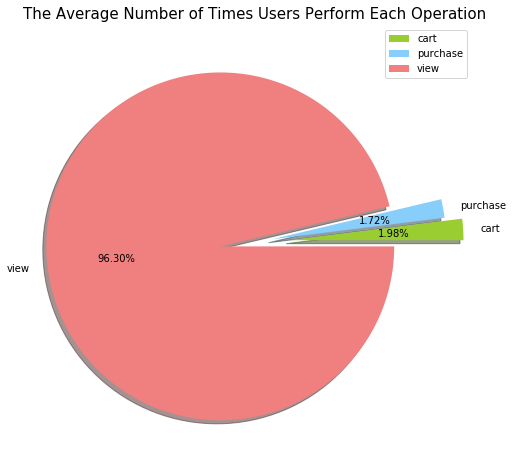

In [10]:
labels = ['cart', 'purchase', 'view']
size = df.groupby('event_type').event_type.count()/df.user_session.nunique()
colors = ['yellowgreen', 'lightskyblue','lightcoral']
explode = [0.2, 0.1, 0.2]
plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, colors = colors, explode = explode,\
labels = labels, shadow = True,  autopct = '%.2f%%') 
plt.title('The Average Number of Times Users Perform Each Operation', fontsize = 15)
plt.axis('off')
plt.legend()
plt.show()

##### 2.1.2 Q2

How many times, on average, a user views a product before adding it to the cart?

In [11]:
df.groupby('event_type').event_type.count()

event_type
cart         200653
purchase     174477
view        9768279
Name: event_type, dtype: int64

In [22]:
et_count = df.groupby('event_type').event_type.count()

In [106]:
print('Answer = ' + str(et_count['view']/et_count['cart']))

Answer = 48.682446811161554


##### 2.1.3 Q3

What’s the probability that products added once to the cart are effectively bought?

In [14]:
type(df.groupby('event_type').event_type.count())

pandas.core.series.Series

In [23]:
#probability that it will go to cart 
p_cart =  et_count['cart']/et_count['view']
#probability that it will go from cart to purchase 
p_purchase = et_count['purchase']/et_count['cart']
# probability it will be bought

In [107]:
print('Answer = ' + str(p_purchase))

Answer = 0.8695459325302886


##### 2.1.4 Q4 

What’s the average time an item stays in the cart before being removed?

##### 2.1.5 Q5 

How much time passes on average between the first view time and a purchase/addition to cart?

### 2.2 RQ2 What are the categories of the most trending products overall? For each month visualize this information through a plot showing the number of sold products per category.
#### 2.2.1 Q1
Plot the most visited subcategories

In [135]:
print('Changing to date format')
df['event_time'] =  pd.to_datetime(df['event_time'])
print('Leaving data until hours')
df['event_time'] = df['event_time'].dt.floor('h')
print('Ready')

Changing to date format


KeyboardInterrupt: 

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10986810 entries, 3 to 67501975
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 838.2+ MB


In [131]:
df1 = df.sample(n=100, random_state=1)

In [132]:
df_10 = df1[pd.to_datetime(df1['event_time']).dt.month == 10]
df_10.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
124215,2019-10-01 04:54:51 UTC,view,1307188,2053013558920217191,computers.notebook,hp,223.69,555475687,6ae6d27a-7010-4e66-8e92-2f726bc50059
3622298,2019-10-04 02:59:43 UTC,view,1500258,2053013552955916539,computers.peripherals.printer,epson,268.99,525742233,7719ecd8-cbb6-4df3-b1f0-960cbca9e9cb
14922406,2019-10-12 09:43:04 UTC,view,4700549,2053013560899928785,auto.accessories.videoregister,neoline,204.12,557285551,c49047e0-845d-4a1a-8bde-57a97b6bd65e
11227414,2019-10-09 16:07:05 UTC,view,22700297,2053013556168753601,NaN,matrix,22.63,514591952,ac671444-c67b-4a1b-a3e8-6a706e0cbb11
16295137,2019-10-13 08:22:54 UTC,view,1003855,2053013555631882655,electronics.smartphone,xiaomi,127.88,559041170,fcf0057a-e015-47c0-9515-df53cd2910c6
